Предсказанные значения для XOR: [[1.92943019e-03]
 [9.96364028e-01]
 [9.95897443e-01]
 [7.30900409e-06]]
Истинные значения для XOR: [[0]
 [1]
 [1]
 [0]]


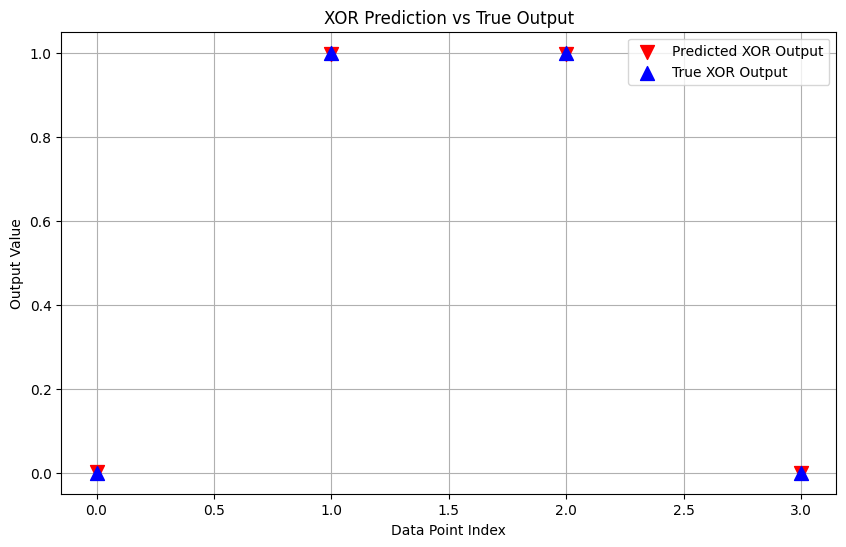

Final Mean Squared Error (MSE): 8.443505010901251e-06


In [7]:
import numpy as np
import pygad
import matplotlib.pyplot as plt

# ===== Класс нейронной сети =====
class NeuralNetworkGA:
    def __init__(self, input_size, hidden_layers, output_size):
        """
        Инициализация нейросети.
        :param input_size: Количество входов.
        :param hidden_layers: Список, где каждый элемент - количество нейронов в каждом скрытом слое.
        :param output_size: Количество выходов.
        """
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.output_size = output_size
        
        # Подсчёт общего количества весов для сети
        self.num_weights = self._count_total_weights()

    def _count_total_weights(self):
        """
        Подсчитывает общее количество весов в сети, включая входные, скрытые и выходные слои.
        """
        total_weights = self.input_size * self.hidden_layers[0]  # Вход -> первый скрытый слой
        for i in range(1, len(self.hidden_layers)):
            total_weights += self.hidden_layers[i-1] * self.hidden_layers[i]  # Между скрытыми слоями
        total_weights += self.hidden_layers[-1] * self.output_size  # Последний скрытый -> выход
        total_weights += sum(self.hidden_layers) + self.output_size  # Включаем смещения (bias)
        return total_weights

    def _activation(self, x):
        """
        Активационная функция (tanh).
        """
        return np.tanh(x)

    def feedforward(self, weights, X):
        """
        Прямой проход через сеть.
        :param weights: Веса сети в виде вектора.
        :param X: Входные данные.
        :return: Предсказанные значения.
        """
        start = 0
        # Вход -> первый скрытый слой
        W = weights[start:start + self.input_size * self.hidden_layers[0]].reshape((self.input_size, self.hidden_layers[0]))
        start += self.input_size * self.hidden_layers[0]
        b = weights[start:start + self.hidden_layers[0]].reshape((1, self.hidden_layers[0]))
        start += self.hidden_layers[0]
        h = self._activation(np.dot(X, W) + b)

        # Прямой проход через скрытые слои
        for i in range(1, len(self.hidden_layers)):
            W = weights[start:start + self.hidden_layers[i-1] * self.hidden_layers[i]].reshape((self.hidden_layers[i-1], self.hidden_layers[i]))
            start += self.hidden_layers[i-1] * self.hidden_layers[i]
            b = weights[start:start + self.hidden_layers[i]].reshape((1, self.hidden_layers[i]))
            start += self.hidden_layers[i]
            h = self._activation(np.dot(h, W) + b)

        # Скрытый -> выходной слой
        W_out = weights[start:start + self.hidden_layers[-1] * self.output_size].reshape((self.hidden_layers[-1], self.output_size))
        start += self.hidden_layers[-1] * self.output_size
        b_out = weights[start:start + self.output_size].reshape((1, self.output_size))
        y_pred = self._activation(np.dot(h, W_out) + b_out)
        return y_pred

# ===== Определяем XOR-данные =====
X_data = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_data = np.array([[0], [1], [1], [0]])

# ===== Настройка гиперпараметров =====
input_size = 2  # Два входа для XOR
output_size = 1  # Один выход
hidden_layers = [4, 4]  # Количество нейронов в скрытых слоях (два скрытых слоя по 4 нейрона каждый)

# Создаем экземпляр сети
nn = NeuralNetworkGA(input_size=input_size, hidden_layers=hidden_layers, output_size=output_size)

# ===== Генетический алгоритм PyGAD =====
# Функция приспособленности для ГА
def fitness_function(ga_instance, solution, solution_idx):
    y_pred = nn.feedforward(solution, X_data)
    mse = np.mean((y_data - y_pred)**2)  # Среднеквадратичная ошибка (MSE)
    return -mse  # Отрицательная MSE, т.к. PyGAD максимизирует

# Настройка генетического алгоритма
ga_instance = pygad.GA(num_generations=200,            # Количество поколений
                       num_parents_mating=10,          # Число родителей для спаривания
                       fitness_func=fitness_function,  # Функция приспособленности
                       sol_per_pop=100,                # Размер популяции
                       num_genes=nn.num_weights,       # Количество генов (весов нейросети)
                       mutation_percent_genes=10)      # Процент генов для мутации

# Запуск генетического алгоритма
ga_instance.run()

# Получение наилучшего решения
best_solution, best_solution_fitness, best_solution_idx = ga_instance.best_solution()

# ===== Визуализация результата =====
y_pred = nn.feedforward(best_solution, X_data)
print(f"Предсказанные значения для XOR: {y_pred}")
print(f"Истинные значения для XOR: {y_data}")

# Визуализация предсказанных значений и истинных
plt.figure(figsize=(10, 6))

# Предсказанные значения (красные треугольники вниз)
plt.scatter(range(4), y_pred, label='Predicted XOR Output', color='red', marker='v', s=100, zorder=5)

# Истинные значения (синие треугольники вверх)
plt.scatter(range(4), y_data, label='True XOR Output', color='blue', marker='^', s=100, zorder=5)

plt.title('XOR Prediction vs True Output')
plt.xlabel('Data Point Index')
plt.ylabel('Output Value')
plt.legend()
plt.grid(True)
plt.show()

# Выводим среднеквадратичную ошибку
mse_final = np.mean((y_data - y_pred)**2)
print(f"Final Mean Squared Error (MSE): {mse_final}")
